# Import Dependencies

In [68]:
import warnings
warnings.filterwarnings('ignore')
import keras
import matplotlib.pyplot as plt

## Define Types

In [69]:
from typing import Tuple
ImageShape = Tuple[int, int]
GrayScaleImageShape = Tuple[int, int, int]

# MNIST Sandbox Baseline Example

In [70]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [71]:
from typing import Tuple
import numpy as np
Dataset = Tuple[np.ndarray, np.ndarray]

#download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of y_test is {y_test.shape} - some example targets: {y_test[:5]}")
mnist_image_shape: ImageShape = X_train.shape[1:]
print(mnist_image_shape)

The shape of X_train is (60000, 28, 28)
The shape of y_train is (60000,)
The shape of X_test is (10000, 28, 28)
The shape of y_test is (10000,) - some example targets: [7 2 1 0 4]
(28, 28)


In [72]:
from keras.utils import to_categorical

OneHotEncodedTarget = np.ndarray
Categories = int
encoded_y_train: OneHotEncodedTarget = to_categorical(y_train)
encoded_y_test: OneHotEncodedTarget = to_categorical(y_test)
print(f"One-hot encoding y_train {y_train.shape} -> {encoded_y_train.shape}")
print(f"One-hot encoding y_test {y_test.shape} -> {encoded_y_test.shape}")

K: Categories = encoded_y_test.shape[1]

One-hot encoding y_train (60000,) -> (60000, 10)
One-hot encoding y_test (10000,) -> (10000, 10)


# Vanilla CNN Implementation

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Input
from tensorflow.python.framework.ops import Tensor
import warnings
warnings.filterwarnings('ignore')

# define model architecture and hyperparameters
NUM_FILTERS_L1 = 64
NUM_FILTERS_L2 = 32
KERNEL_SIZE = 3

# the images are 28 x 28 (pixel size) x 1 (grayscale - if RGB, then 3)
input_dims: GrayScaleImageShape = (28,28,1)

def build_vanilla_cnn(filters_layer1:int, filters_layer2:int, kernel_size:int, input_dims: GrayScaleImageShape)-> Model:
    inputs: Tensor = Input(shape=input_dims)
    x: Tensor = Conv2D(filters=filters_layer1, kernel_size=kernel_size, activation='relu')(inputs)
    x: Tensor = Conv2D(filters=filters_layer2, kernel_size=kernel_size, activation='relu')(x)
    x: Tensor = Flatten()(x)
    predictions = Dense(K, activation="softmax")(x)
    print(predictions)

    #compile model using accuracy to measure model performance
    model: Model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    return model

model: Model = build_vanilla_cnn(NUM_FILTERS_L1, NUM_FILTERS_L2, KERNEL_SIZE, input_dims)

Tensor("dense_3/Softmax:0", shape=(?, 10), dtype=float32)


In [78]:
X_train.reshape((60000,1,28,28))

def expand_tensor_shape(X_train: np.ndarray)-> np.ndarray:
    new_shape: Tuple = X_train.shape + (1,)
        
#     new_tensor = X_train.reshape(new_shape).reshape((-1,1,28,28))
    new_tensor = X_train.reshape(new_shape)
    print(f"Expanding shape from {X_train.shape} to {new_tensor.shape}")
    return new_tensor

X_train_expanded: np.ndarray = expand_tensor_shape(X_train)
X_test_expanded: np.ndarray = expand_tensor_shape(X_test)
    
    
# train model and retrieve history
# from keras.callbacks import History
# history: History = model.fit(X_train_expanded, encoded_y_train, 
#                              validation_data=(X_test_expanded, encoded_y_test), epochs=2, batch_size=2058)

Expanding shape from (60000, 28, 28) to (60000, 28, 28, 1)
Expanding shape from (10000, 28, 28) to (10000, 28, 28, 1)


## Global Average Pooling Layer

Output shape of convolutional layer is typically `batch size x number of filters x width x height`. The GAP layer will take the average of the width/height axis

In [79]:
from keras import backend as K

In [80]:
np.reshape(X_train_expanded, (-1,1,28,28)).shape

(60000, 1, 28, 28)

In [81]:
from keras.layers import Layer, Lambda
def global_average_pooling(x: Layer):
    return K.mean(x, axis = (2,3))

def global_average_pooling_shape(input_shape):
    # return only the first two dimensions (batch size and number of filters)
    return input_shape[0:2]

def build_global_average_pooling_layer(function, output_shape):
    return Lambda(pooling_function, output_shape)


def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [90]:
###### from keras.layers import Layer, Lambda, Input
from tensorflow.python.framework.ops import Tensor
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPool2D
from tensorflow.python.framework.ops import Tensor
def global_average_pooling(x: Layer):
    return K.mean(x, axis = (2,3))

def global_average_pooling_shape(input_shape):
    # return the dimensions corresponding with batch size and number of filters
    return (input_shape[0], input_shape[-1])

def build_global_average_pooling_layer(function, output_shape):
    return Lambda(pooling_function, output_shape)

inputs: Tensor = Input(shape=(28,28,1))
x: Tensor = Conv2D(filters=32, kernel_size=5, activation='relu')(inputs)
x: Tensor = MaxPool2D()(x)
x: Tensor = Conv2D(filters=64, kernel_size=5, activation='relu')(x)
x: Tensor = Lambda(lambda x: K.mean(x, axis=(1,2)), output_shape=global_average_pooling_shape)(x)
x: Tensor = Dense(128, activation="relu")(x)
predictions: Tensor = Dense(10, activation="softmax")(x)
model: Model = Model(inputs=inputs, outputs=predictions)
model.summary()
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
from keras.callbacks import History
history: History = model.fit(X_train_expanded, encoded_y_train,  
                             validation_data=(X_test_expanded, encoded_y_test), epochs=100, batch_size=5126)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
lambda_12 (Lambda)           (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_21 (Dense)             (None, 10)                1290      
Total para

60000/60000 [==============================] - 18s - loss: 0.0362 - acc: 0.9890 - val_loss: 0.0433 - val_acc: 0.9857
Epoch 54/100
60000/60000 [==============================] - 19s - loss: 0.0349 - acc: 0.9897 - val_loss: 0.0447 - val_acc: 0.9860
Epoch 55/100
60000/60000 [==============================] - 18s - loss: 0.0354 - acc: 0.9895 - val_loss: 0.0430 - val_acc: 0.9865
Epoch 56/100
60000/60000 [==============================] - 19s - loss: 0.0342 - acc: 0.9897 - val_loss: 0.0416 - val_acc: 0.9868
Epoch 57/100
60000/60000 [==============================] - 20s - loss: 0.0320 - acc: 0.9906 - val_loss: 0.0419 - val_acc: 0.9867
Epoch 58/100
60000/60000 [==============================] - 19s - loss: 0.0319 - acc: 0.9904 - val_loss: 0.0408 - val_acc: 0.9874
Epoch 59/100
60000/60000 [==============================] - 18s - loss: 0.0319 - acc: 0.9905 - val_loss: 0.0395 - val_acc: 0.9869
Epoch 60/100
60000/60000 [==============================] - 19s - loss: 0.0334 - acc: 0.9896 - val_loss

## Save the Class Activation Model Weights

In [91]:
# persist model
save_filepath: str = "class_activation_max_pool.h5"
model.save(save_filepath)

In [61]:
first_image = X_train[2]
first_image = first_image.reshape(28,28,1)
img = np.array(first_image).reshape(1, 28, 28, 1)
img.shape
# img = np.array([np.transpose(np.float32(first_image), (2, 0, 1))])
# img.shape



(1, 28, 28, 1)

In [62]:
class_weights: np.ndarray = model.layers[-1].get_weights()[0] # class weights is of shape 32 x 10 (number of filter outputs x classes)
print(f"Class weights is shape {class_weights.shape}")
final_conv_layer: Conv2D = get_output_layer(model, "conv2d_3")

input_tensor: Tensor = model.layers[0].input
final_conv_layer_output: Tensor = final_conv_layer.output
model_class_weights: Tensor = model.layers[-1].output
    
# K.function is a function factory that accepts arbitrary input layers and outputs arbitrary output layers
get_output = K.function([input_tensor], [final_conv_layer_output, model_class_weights])

[conv_outputs, predictions] = get_output([img])
print("Conv2D output shape:", conv_outputs.shape) # should match the shape of the outputs from the Conv2D layer
print("Predictions:", predictions.shape)
np.argmax(predictions)
# [conv_outputs, predictions] = get_output([img])
# conv_outputs = conv_outputs[0, :, :, :]

Class weights is shape (64, 10)
Conv2D output shape: (1, 26, 26, 64)
Predictions: (1, 10)


4

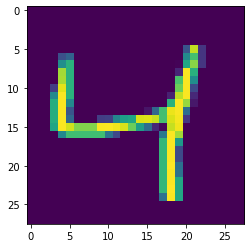

In [63]:
plt.imshow(first_image.reshape((28,28)))

In [ ]:
        #Reshape to the network input shape (3, w, h).
        img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = get_output_layer(model, "conv5_3")
        get_output = K.function([model.layers[0].input], \
                    [final_conv_layer.output, 
        model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        target_class = 1
        for i, w in enumerate(class_weights[:, target_class]):
                cam += w * conv_outputs[i, :, :]

In [78]:
image_path = 
original_img = cv2.imread(image_path, 1)
width, height, _ = original_image.shape

In [24]:


def build_vanilla_cnn(filters_layer1:int, filters_layer2:int, kernel_size:int, input_dims: GrayScaleImageShape)-> Model:
    inputs: Tensor = Input(shape=input_dims)
    x: Tensor = Conv2D(filters=filters_layer1, kernel_size=kernel_size, activation='relu')(inputs)
    x: Tensor = Conv2D(filters=filters_layer2, kernel_size=kernel_size, activation='relu')(x)
    x: Tensor = build_global_average_pooling_layer(global_average_pooling, )
    predictions = Dense(K, activation="softmax")(x)
    print(predictions)

    #compile model using accuracy to measure model performance
    model: Model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    return model

# Example Attention Model

In [11]:
inputs = Input(shape=input_dims)

In [134]:
from keras.layers import merge

def build_model(input_dim):
    inputs = Input(shape=input_dim)

    # ATTENTION PART STARTS HERE
    attention_probs = Dense(input_dim, activation='softmax', name='attention_vec')(inputs)
    attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
    # ATTENTION PART FINISHES HERE

    attention_mul = Dense(64)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

inputs = Input(shape=input_dims)
attention_probs = Dense(input_dims, activation='softmax', name='attention_vec')(inputs)

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

## Compile and Fit Model

In [121]:
X_train.reshape((60000,1,28,28))

def expand_tensor_shape(X_train: np.ndarray)-> np.ndarray:
    new_shape: Tuple = X_train.shape + (1,)
    print(f"Expanding shape from {X_train.shape} to {new_shape}")
    return X_train.reshape(new_shape)

X_train_expanded: np.ndarray = expand_tensor_shape(X_train)
X_test_expanded: np.ndarray = expand_tensor_shape(X_test)

Expanding shape from (60000, 28, 28) to (60000, 28, 28, 1)
Expanding shape from (10000, 28, 28) to (10000, 28, 28, 1)


# FEI Face Dataset

In [12]:
from PIL.JpegImagePlugin import JpegImageFile

image: JpegImageFile = load_img('1-01.jpg')

PIL.JpegImagePlugin.JpegImageFile